In [38]:
%matplotlib inline

import numpy as np
import pandas as pd
import uproot
from hep_ml import reweight
from matplotlib import pyplot as plt

In [39]:
columns = ['hh_vec_mass', 'HT','higgs1_reco_pt', 'higgs1_reco_eta', 'higgs1_reco_phi','higgs2_reco_pt', 'higgs2_reco_eta', 'higgs2_reco_phi']
#columns = ['HT']
with uproot.open('data_2b.root',
                            httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                            ) as original_file:
    original_tree = original_file['tree']
    original = original_tree.arrays(library='pd')
with uproot.open('data_4b.root',
                          httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                          ) as target_file:
    target_tree = target_file['tree']
    target = target_tree.arrays(library='pd')
original_weights = np.ones(len(original))

In [40]:
from sklearn.model_selection import train_test_split

# divide original samples into training ant test parts
original_train, original_test = train_test_split(original)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(target)

original_weights_train = np.ones(len(original_train))
original_weights_test = np.ones(len(original_test))

In [41]:
from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}


def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[30, 30])
    for id, column in enumerate(columns, 1):
        xlim = np.percentile(np.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(3, 3, id)
        plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[column], range=xlim, **hist_settings)
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column],
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))

In [17]:
len(original), len(target)

(1386156, 26274)

KS over  hh_vec_mass  =  0.03264938902488185
KS over  HT  =  0.14574730480506848
KS over  higgs1_reco_pt  =  0.06053279955705482
KS over  higgs1_reco_eta  =  0.012108379637123634
KS over  higgs1_reco_phi  =  0.005844064788652736
KS over  higgs2_reco_pt  =  0.020362829048206132
KS over  higgs2_reco_eta  =  0.010910599012069477
KS over  higgs2_reco_phi  =  0.004291353816310711


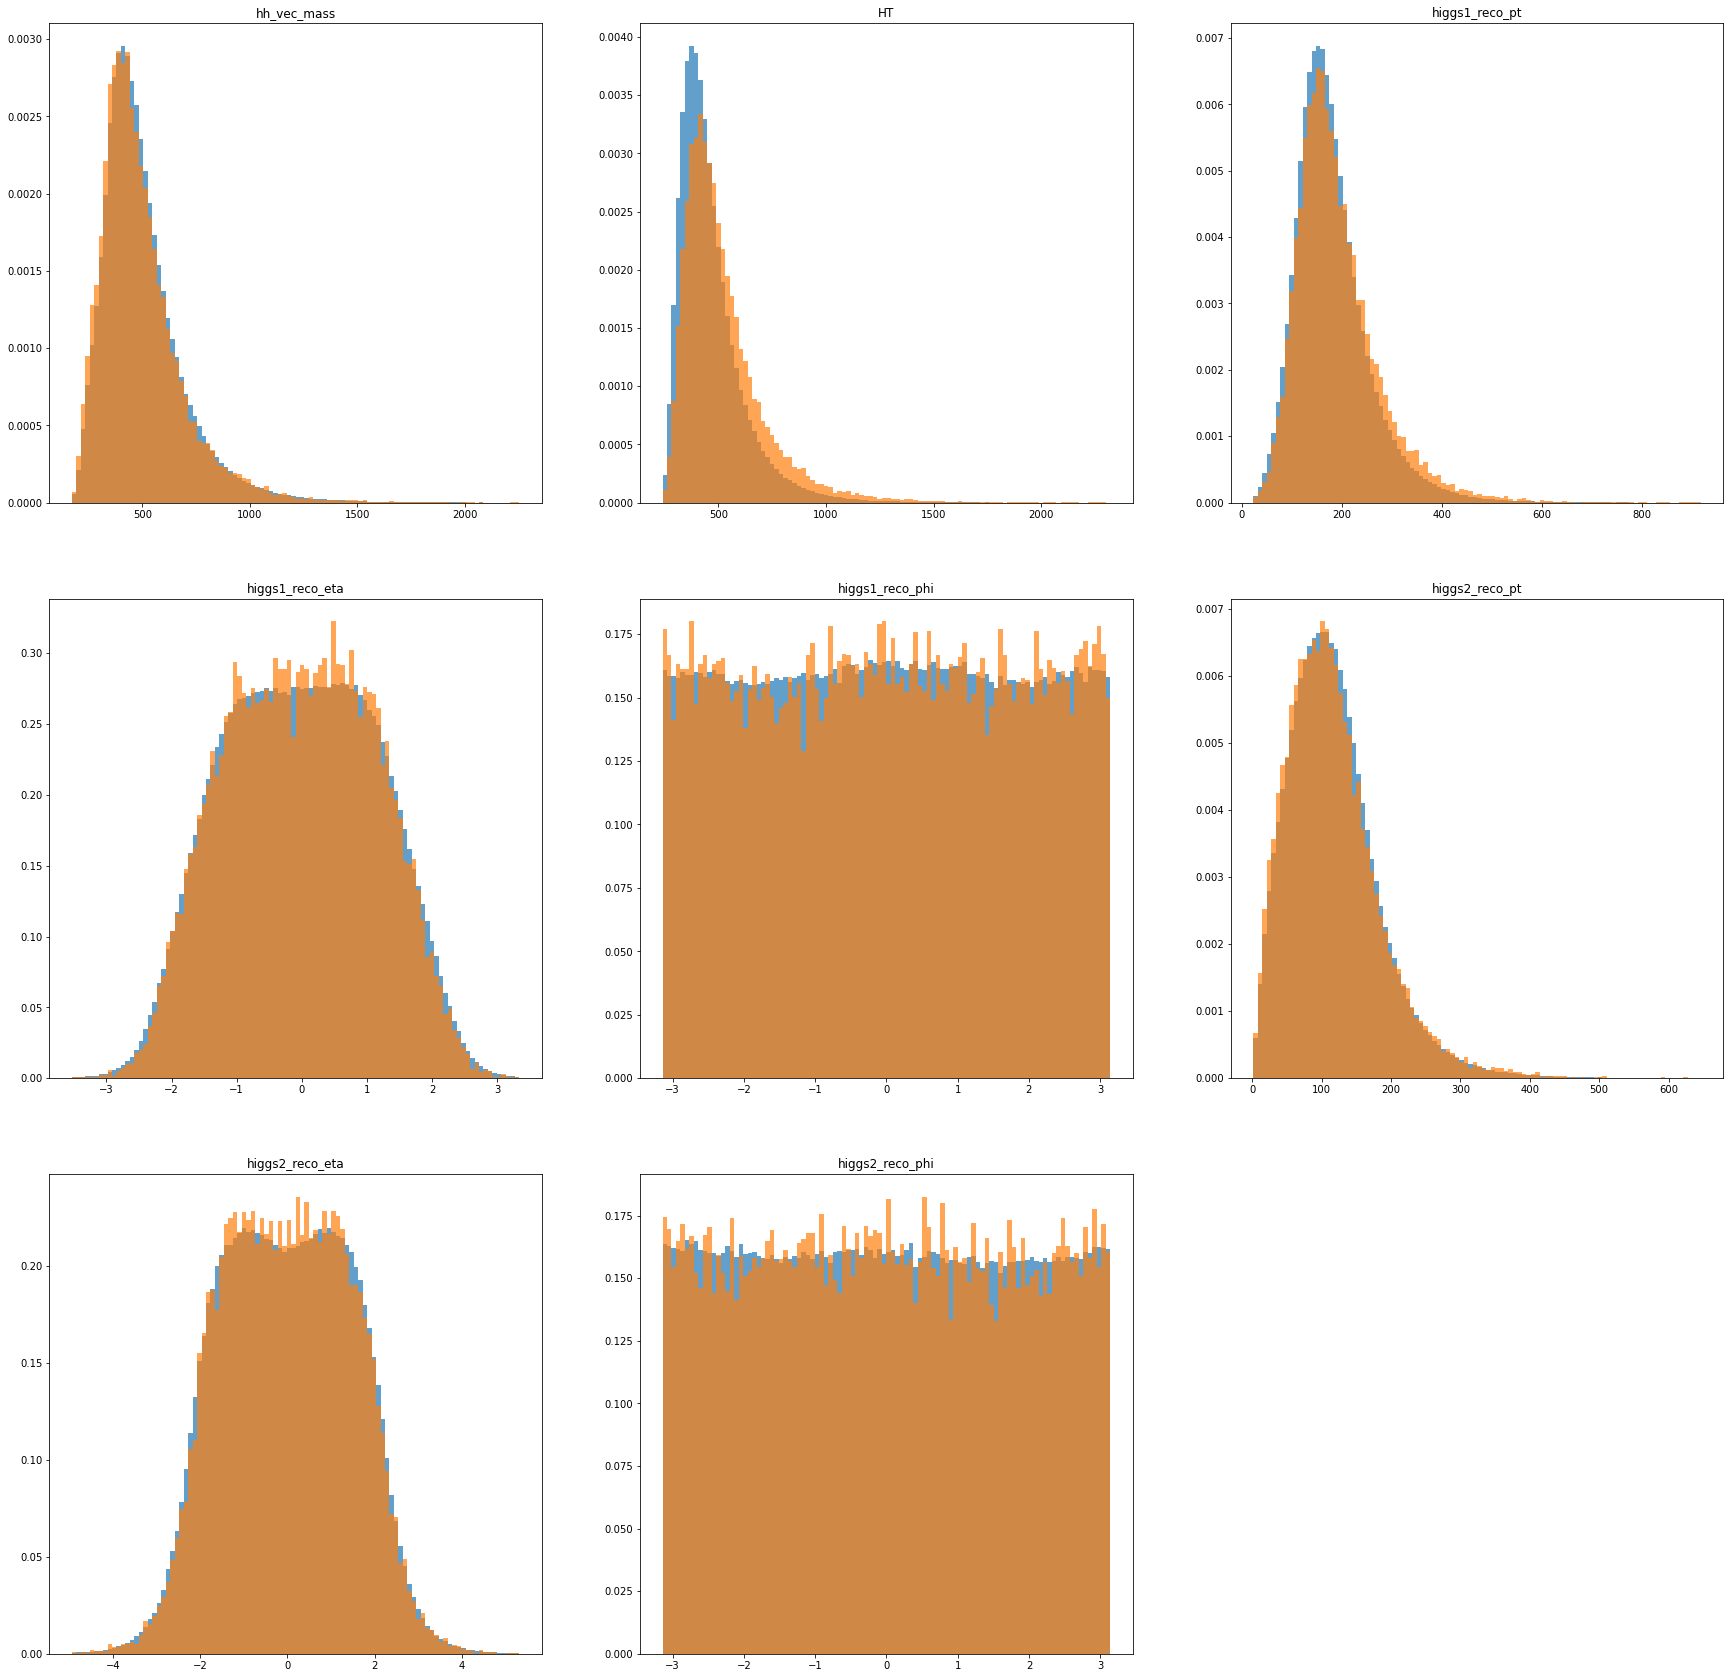

In [42]:
draw_distributions(original, target, original_weights)

KS over  hh_vec_mass  =  0.0312953972200552
KS over  HT  =  0.14497770561007828
KS over  higgs1_reco_pt  =  0.05870166362803109
KS over  higgs1_reco_eta  =  0.013193366468247869
KS over  higgs1_reco_phi  =  0.006105669656665036
KS over  higgs2_reco_pt  =  0.019873945135688298
KS over  higgs2_reco_eta  =  0.010804894012572674
KS over  higgs2_reco_phi  =  0.005819539896403381


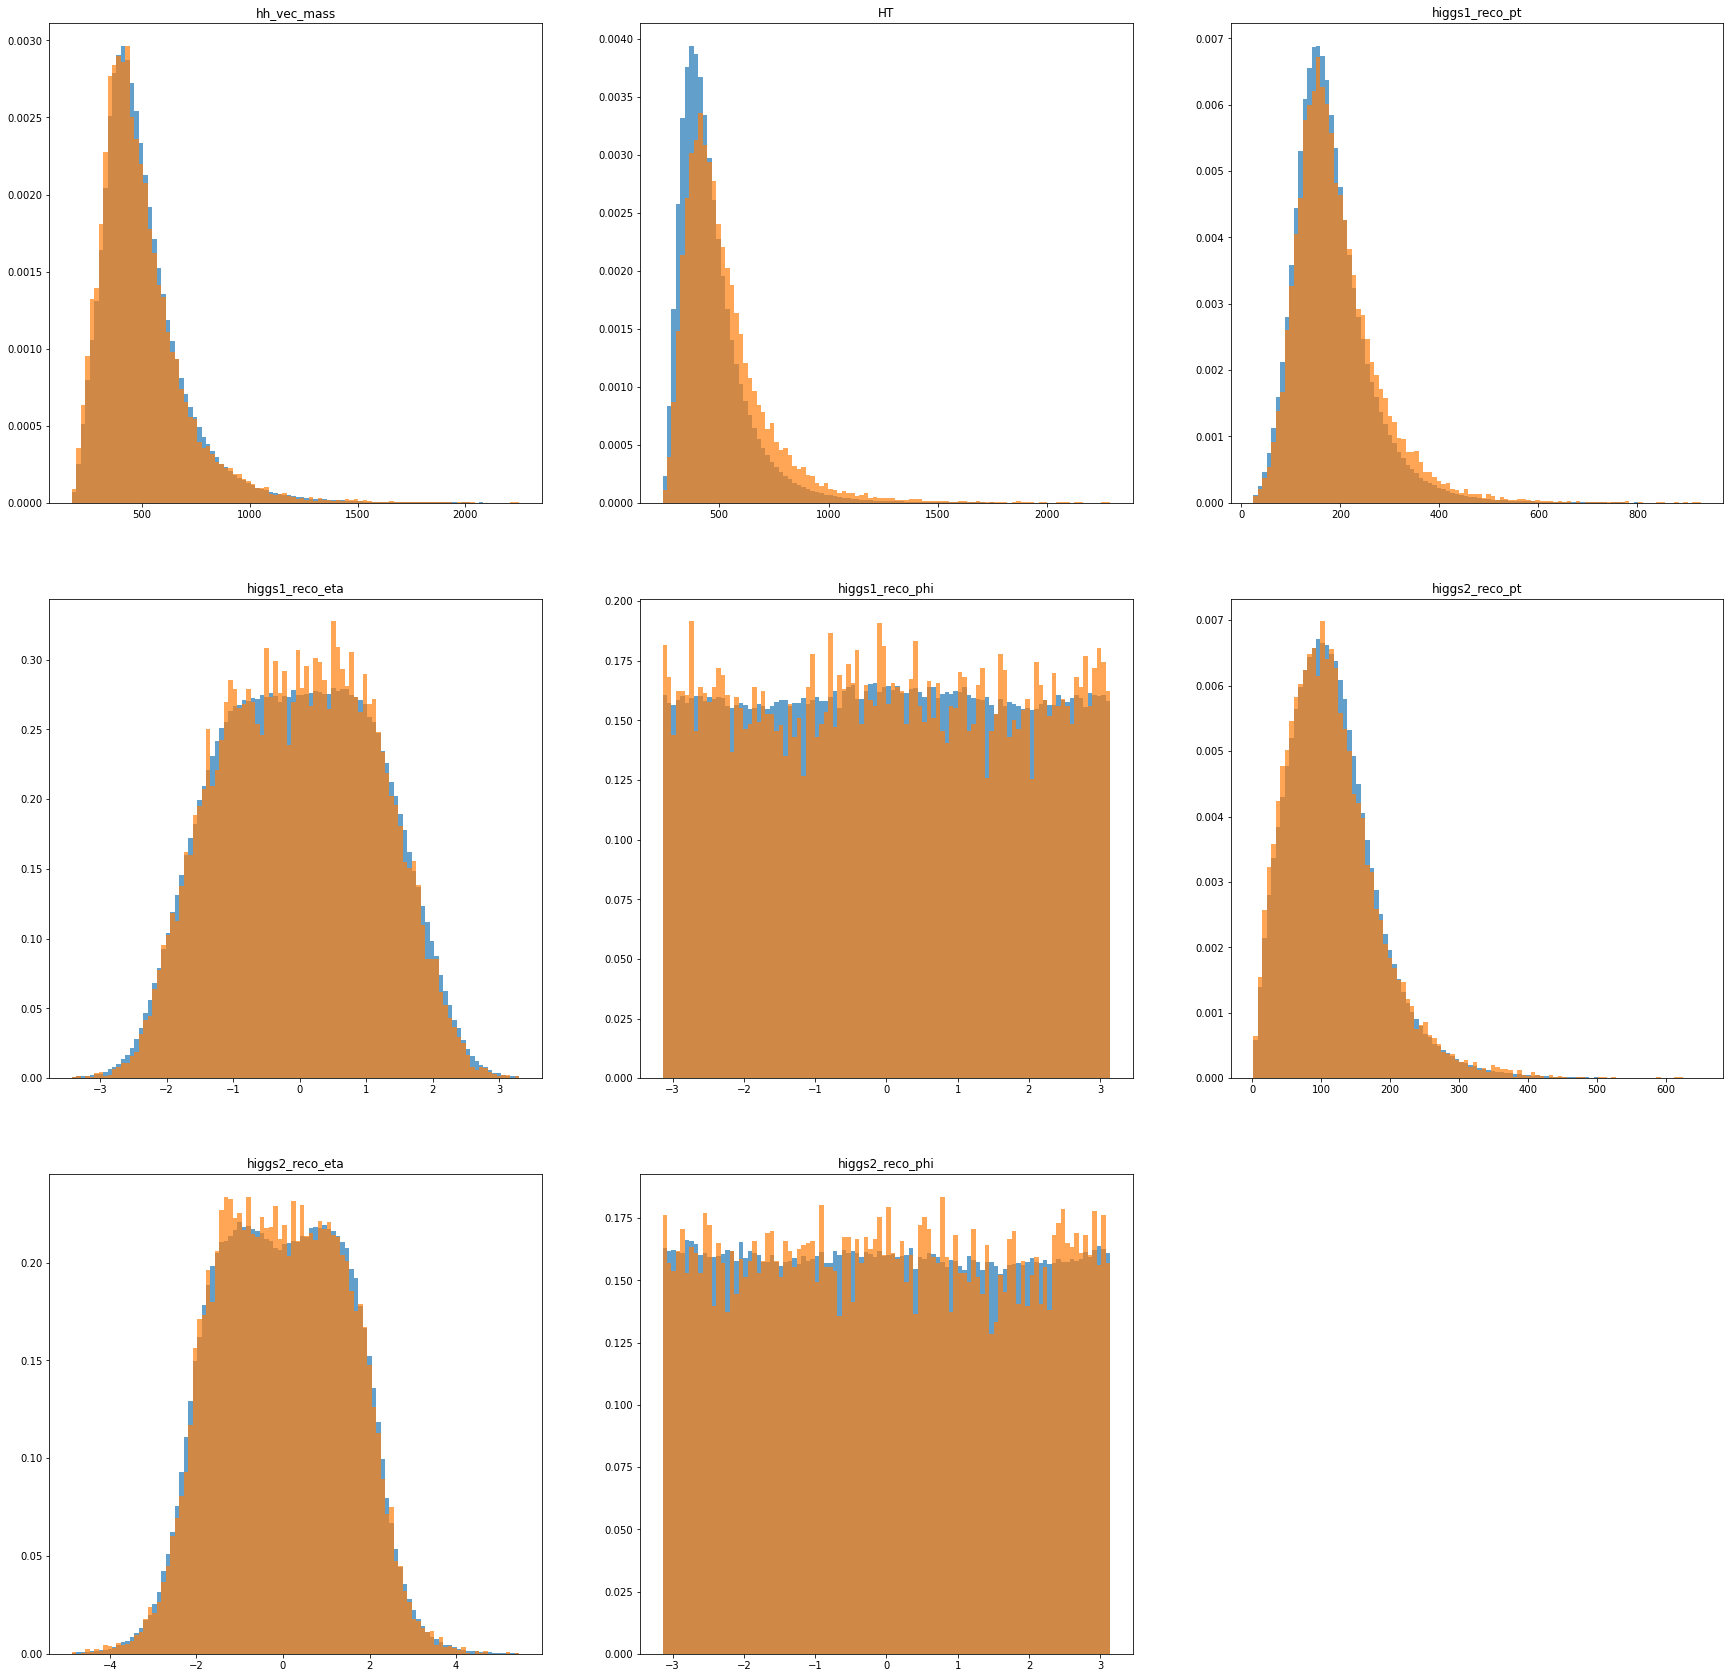

In [43]:
draw_distributions(original_train, target_train, original_weights_train)

KS over  hh_vec_mass  =  0.03788438233216598
KS over  HT  =  0.15127182181064142
KS over  higgs1_reco_pt  =  0.0667888202010003
KS over  higgs1_reco_eta  =  0.012867887655039767
KS over  higgs1_reco_phi  =  0.01397198130383337
KS over  higgs2_reco_pt  =  0.02326411866264738
KS over  higgs2_reco_eta  =  0.01938862355564991
KS over  higgs2_reco_phi  =  0.009517650974869007
[1. 1. 1. ... 1. 1. 1.]


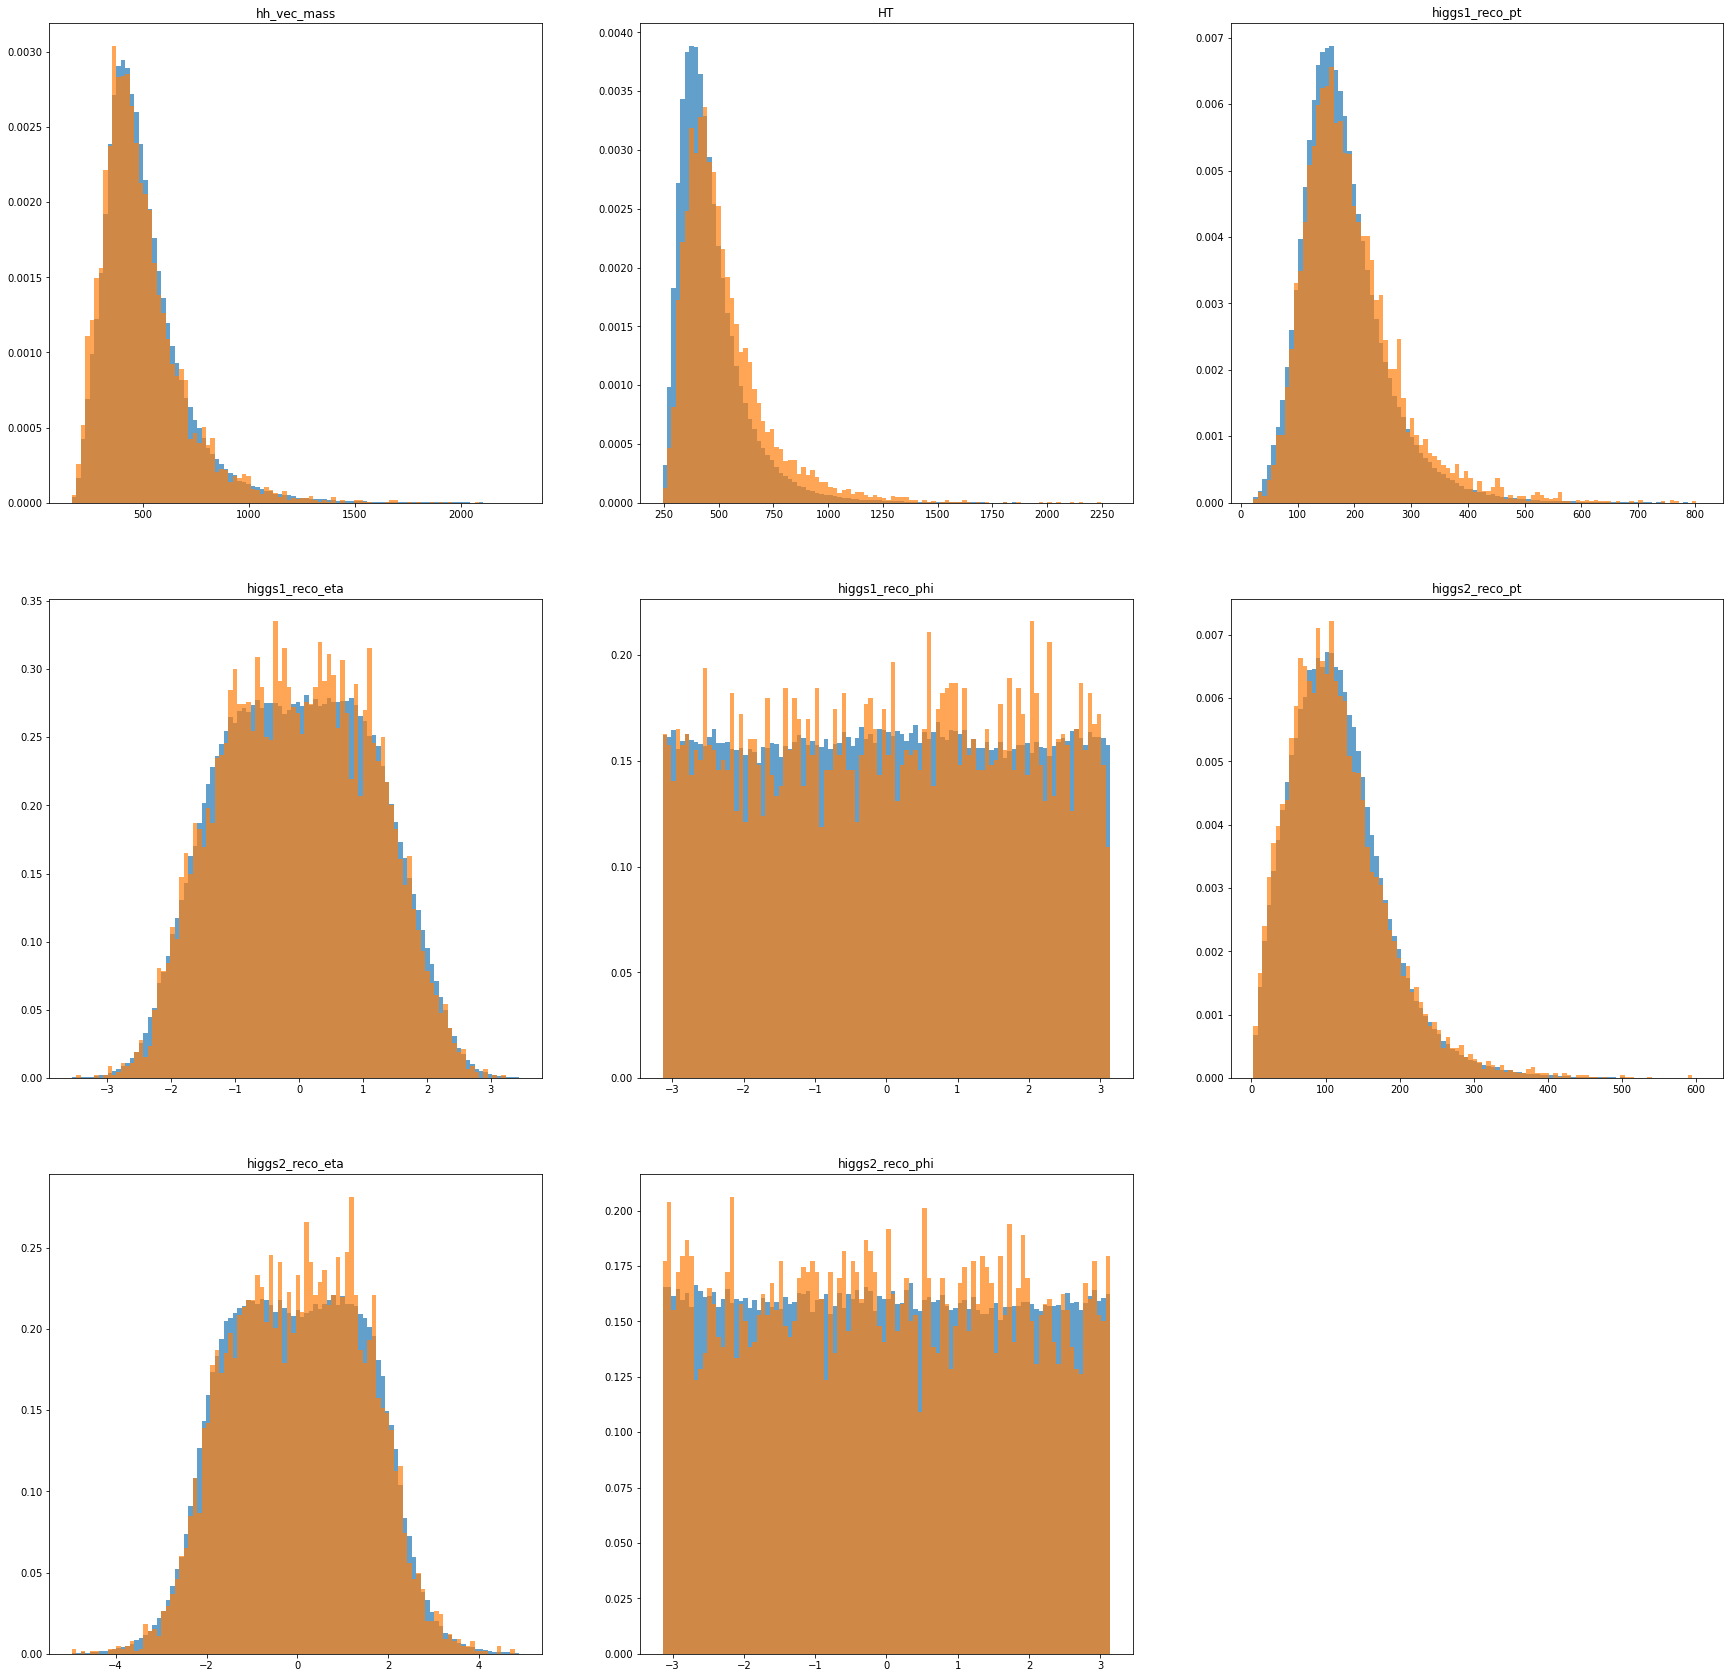

In [44]:
draw_distributions(original_test, target_test, original_weights_test)
print(original_weights_test)

KS over  hh_vec_mass  =  0.03788438233216598
KS over  HT  =  0.15127182181064142
KS over  higgs1_reco_pt  =  0.0667888202010003
KS over  higgs1_reco_eta  =  0.012867887655039767
KS over  higgs1_reco_phi  =  0.01397198130383337
KS over  higgs2_reco_pt  =  0.02326411866264738
KS over  higgs2_reco_eta  =  0.01938862355564991
KS over  higgs2_reco_phi  =  0.009517650974869007


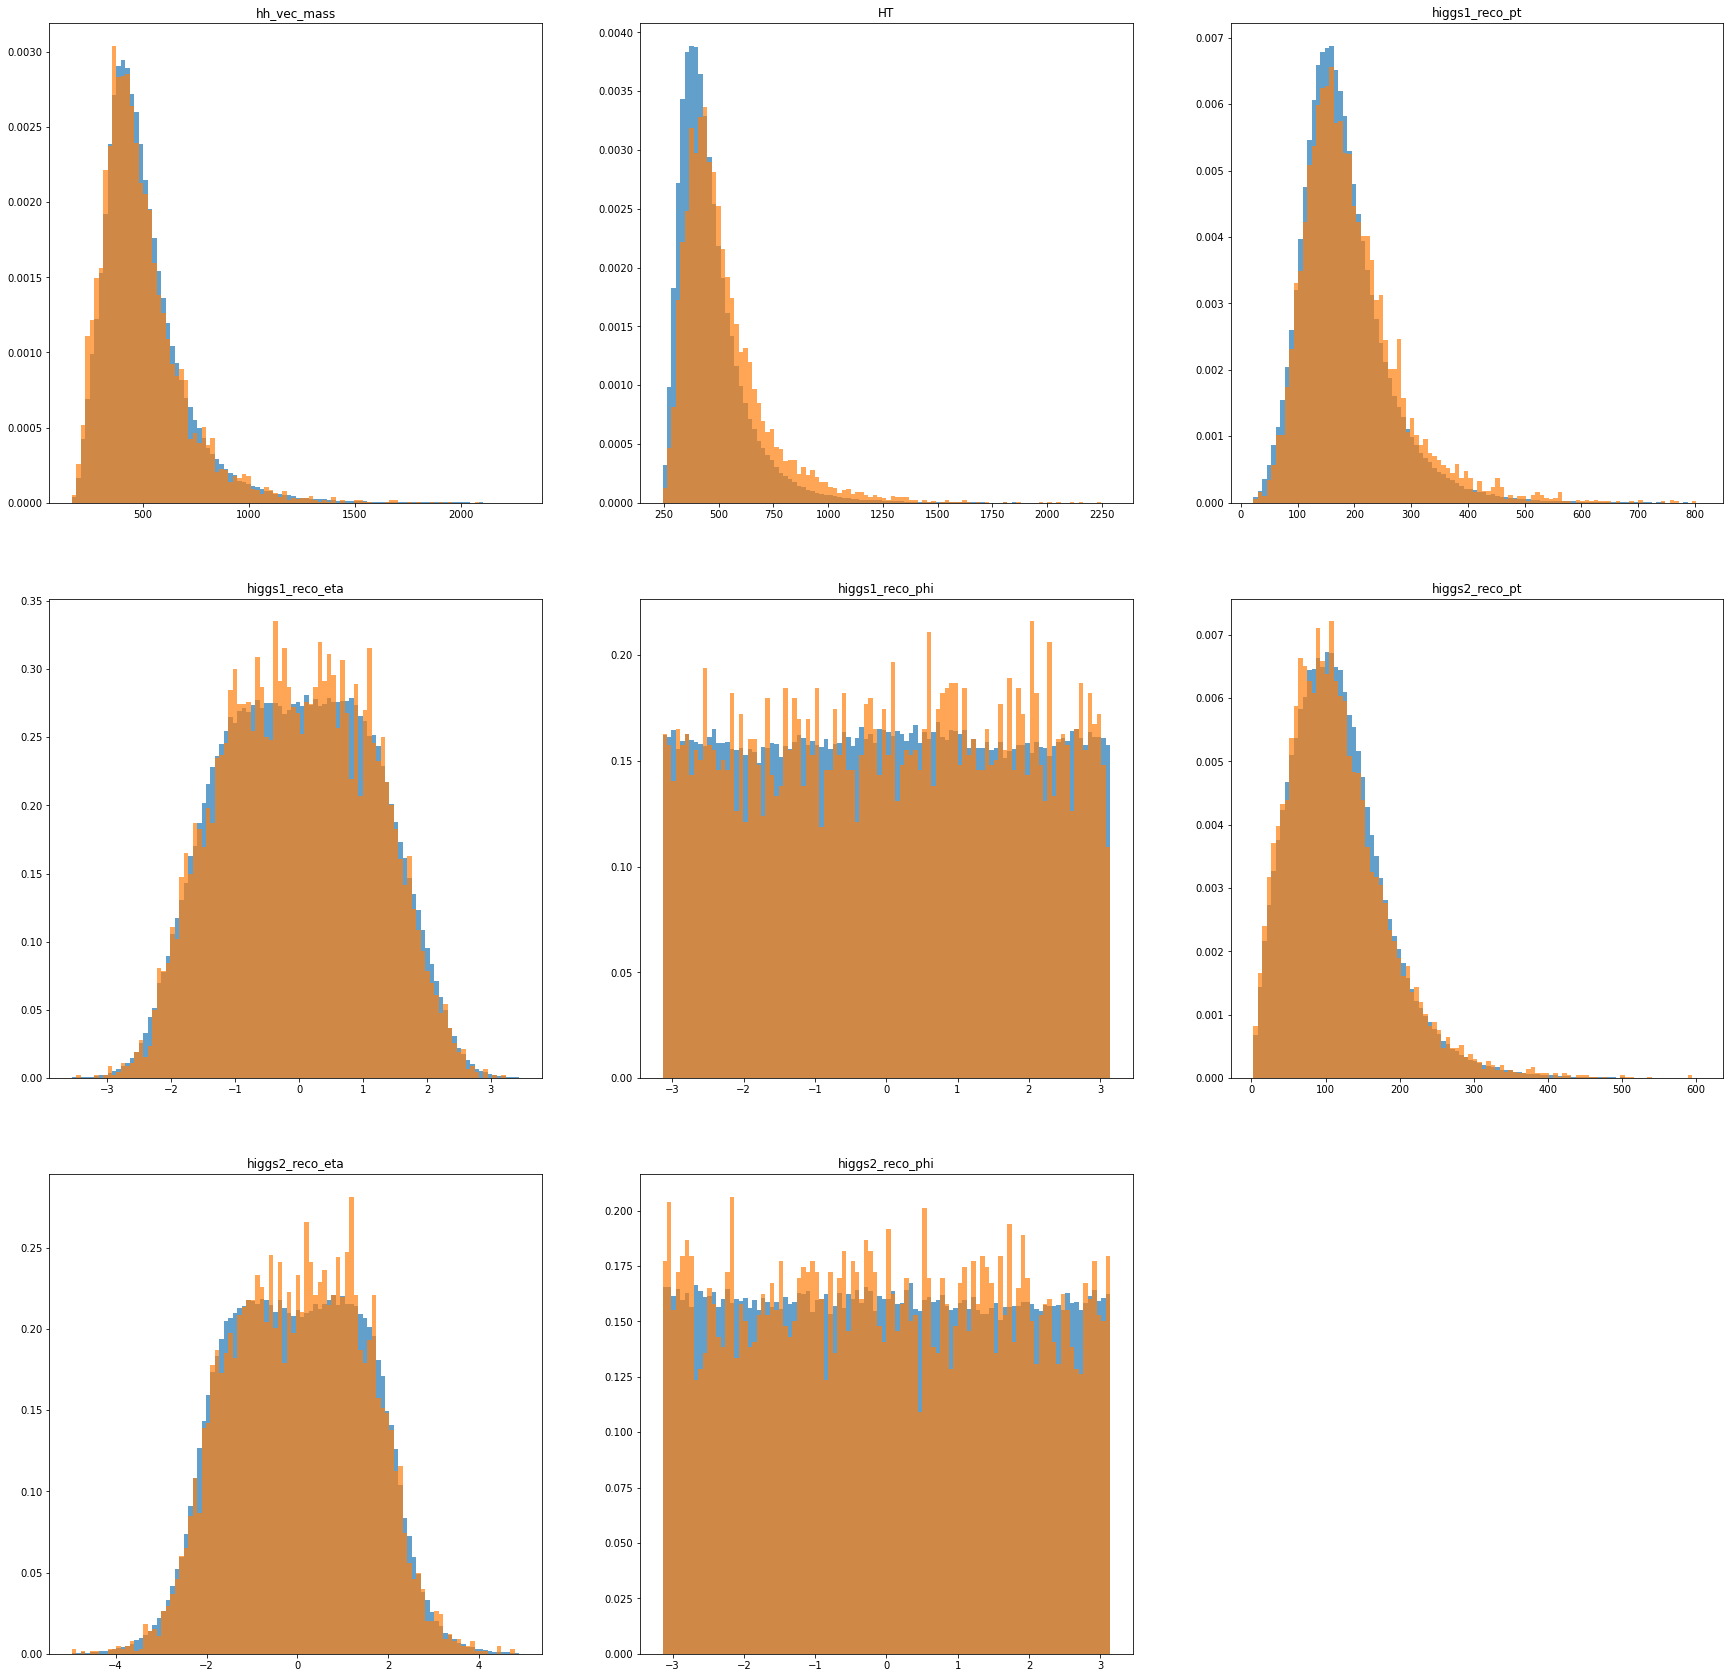

In [45]:
reweighter = reweight.GBReweighter(n_estimators=30, learning_rate=0.1, max_depth=3, min_samples_leaf=100,
                                   gb_args={'subsample': 0.4})
reweighter.fit(original_train, target_train)

gb_weights_test = reweighter.predict_weights(original_test)

# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, gb_weights_test)

In [36]:
print(len(original_weights_train)+len(gb_weights_test))

1386156


In [10]:
def check_ks_of_expression(expression):
    col_original = original_test.eval(expression, engine='python')
    col_target = target_test.eval(expression, engine='python')
    w_target = np.ones(len(col_target), dtype='float')
    print('No reweight   KS:', ks_2samp_weighted(col_original, col_target,
                                                 weights1=original_weights_test, weights2=w_target))
    print('GB Reweight   KS:', ks_2samp_weighted(col_original, col_target,
                                                 weights1=gb_weights_test, weights2=w_target))

In [11]:
check_ks_of_expression('HT')

No reweight   KS: 0.15143795893833584
GB Reweight   KS: 0.1514665901402132


In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

data = np.concatenate([original_test, target_test])
labels = np.array([0] * len(original_test) + [1] * len(target_test))

weights = {}
weights['original'] = original_weights_test
weights['gb_weights'] = gb_weights_test


for name, new_weights in weights.items():
    W = np.concatenate([new_weights / new_weights.sum() * len(target_test), [1] * len(target_test)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)

    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 1.0
gb_weights 1.0


Text(0.5, 1.0, 'predicted weights')

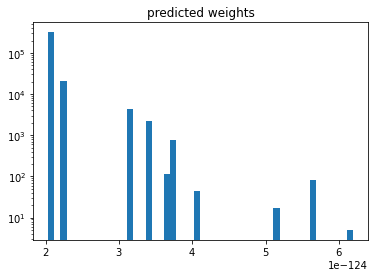

In [23]:
plt.hist(weights['gb_weights'], bins=50)
plt.yscale('log')
plt.title('predicted weights')

In [31]:
np.sum(weights['gb_weights'])

3.604397775117461e-97

In [32]:
np.sum(weights['original'])

6569.0

In [ ]:
# define base reweighter
reweighter_base = reweight.GBReweighter(n_estimators=80,
                                        learning_rate=0.01, max_depth=4, min_samples_leaf=100,
                                        gb_args={'subsample': 0.8})
reweighter = reweight.FoldingReweighter(reweighter_base, n_folds=2)
# it is not needed divide data into train/test parts; reweighter can be train on the whole samples
reweighter.fit(original, target)

# predict method provides unbiased weights prediction for the whole sample
# folding reweighter contains two reweighters, each is trained on one half of samples
# during predictions each reweighter predicts another half of samples not used in training
folding_weights = reweighter.predict_weights(original)

draw_distributions(original, target, folding_weights)